In [1]:
import numpy as np

# สมมติ embedding 2 vectors ขนาด 128 มิติ
embedding_a = np.random.rand(128)
embedding_b = np.random.rand(128)

# 1. Euclidean Distance เวคเตอร์เอามาลบกัน - 
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# 2. Cosine Similarity  # คำนวณ dot product แล้วหารด้วย norm ของแต่ละเวคเตอร์
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# 3. Cosine Distance = 1 - Cosine Similarity
def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)

print("Euclidean Distance:", euclidean_distance(embedding_a, embedding_b))
print("Cosine Similarity:", cosine_similarity(embedding_a, embedding_b))
print("Cosine Distance:", cosine_distance(embedding_a, embedding_b))


Euclidean Distance: 4.587368906030466
Cosine Similarity: 0.7457475723135644
Cosine Distance: 0.25425242768643563


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
import os
import cv2
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import matplotlib

#from tensorflow.keras import model


In [39]:
from keras.models import load_model

model = load_model(r'D:\final_facenet\model\60per.h5')
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [27]:
def Nornal(image_path):
    """
    โหลดและประมวลผลภาพอย่างปลอดภัย - แก้ไข NaN
    """
        # อ่านไฟล์
    image = tf.io.read_file(image_path)
        
        # Decode image
    image = tf.image.decode_image(image, channels=3)
        
        # แปลงเป็น float32 ก่อน resize
    image = tf.cast(image, tf.float32)
        
        # Resize
    image = tf.image.resize(image, [224, 224])
        
        # Normalize อย่างปลอดภัย
    image = (image * 255.0 - 127.5) / 128.0
        
        # ตรวจสอบค่าผิดปกติ
    #image = tf.clip_by_value(image, 0.0, 1.0)
        #print(image)
        # ตรวจสอบ NaN หรือ Inf
    #image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
        
        # กำหนด shape
    image.set_shape((224, 224, 3))

    image = tf.expand_dims(image, axis=0) # เพิ่ม batch dimension
 
    return image


In [28]:
def Nornal1(image_array):
    """
    รับ NumPy image แล้วทำ preprocessing
    """
    image = tf.convert_to_tensor(image_array, dtype=tf.float32)

    # Resize
    image = tf.image.resize(image, [224, 224])

    # Normalize: scale to [-1, 1] เช่นเดียวกับที่ใช้ใน FaceNet
    image = (image * 255.0 - 127.5) / 128.0

    # Set shape
    image.set_shape((224, 224, 3))

    # เพิ่ม batch dimension
    image = tf.expand_dims(image, axis=0)

    return image


In [29]:
def loadimagepng(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32)
        img = img / 255.0  # Normalization
        img = tf.where(tf.math.is_finite(img), img, tf.zeros_like(img)) # แทนที่ค่า NaN หรือ Inf ด้วย 0
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img
    except:
        print(f"Error loading image {image_path}. Returning a zero tensor.")
        return tf.zeros((224, 224, 3), dtype=tf.float32)

In [30]:
def loadimage(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [224, 224]) # Facenet มักใช้ 160x160 หรือ 224x224
        image = image / 255.0 # Normalize เป็น 0-1
        image = tf.clip_by_value(image, 0.0, 1.0)
        image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
        image.set_shape((224, 224, 3)) # กำหนด Shape ให้ชัดเจน
        return image
    except Exception as e:
        print(f"⚠️ Error loading {image_path}: {e}")
        return tf.zeros((224, 224, 3), dtype=tf.float32) # ส่งภาพดำกลับไป

In [31]:
import matplotlib.pyplot as plt


In [32]:
print("Model loaded successfully.")

Model loaded successfully.


In [33]:
detector = MTCNN()

# load the input image and convert it to grayscale
#image = cv2.imread(r'C:\InceptionNet\T1\T1.jpg') #เก็บภาพในตัวแปร ,OpenCV จะโหลดภาพมาในรูปแบบ BGR (สีน้ำเงิน, เขียว, แดง) #แสดงภาพต้นฉบับ 
def cap(image): 
    imageM = cv2.imread(image) 
    rgb_image = cv2.cvtColor(imageM, cv2.COLOR_BGR2RGB) #แปลงสีภาพจาก BGR เป็น RGB
    results = detector.detect_faces(rgb_image) #box  confidence keypoints
    for face in results:
        x, y, width, height = face['box'] #face['box'] = [100, 150, 60, 60]  x = 100, y = 150, width = 60, height = 60
        x2, y2 = x + width, y + height #  2 จุด 
        """ดึงตำแหน่งกรอบใบหน้าจาก dictionary ที่ key box
        (x, y) คือพิกัดมุมซ้ายบนของใบหน้า
        width คือความกว้างของกรอบใบหน้า
        height คือความสูงของกรอบใบหน้า"""
        # วาดกรอบสีเขียวรอบใบหน้า
        #cv2.rectangle(imageM, (x, y), (x2, y2), (0, 255, 0), 2) #cv2.rectangle(image, pt1, pt2, color, thickness)
        
        i = rgb_image[y:y2, x:x2]

        
        
        return i





In [41]:
Image1 = r'D:\final_facenet\Dataset\T1\f.jpg'
Image2 = r'D:\final_facenet\Dataset\t2\T1.jpg'
Image1c = cap(Image1)
Image2c = cap(Image2)
print("Image1c:", Image1c.shape)
print("Image1c:", Image2c.shape)

1/1 [==============================] - 0s 32ms/step
Image1c: (364, 312, 3)
Image1c: (319, 247, 3)


In [42]:
nor1 = Nornal1(Image1c)
em1 = model.predict(nor1)

nor2 = Nornal1(Image2c)
em2 = model.predict(nor2)


print("Embedding vector:", em1)
print("Embedding vector:", em2)

print(em1.shape)
print(em2.shape)
print(nor1.shape)
print(nor2.shape)

#print("Embedding vector:", em2)

1/1 [==============================] - 0s 44ms/step
Embedding vector: [[-1.10542756e-02 -1.52897537e-01  1.83970749e-01  7.63570219e-02
   2.45223790e-02  6.22245781e-02 -9.52311978e-02  6.37258515e-02
   3.17619778e-02 -5.58098018e-01  2.96119954e-02  8.04872513e-02
  -3.46235512e-03 -1.49260834e-01  7.29322359e-02 -1.62455216e-01
   7.50974799e-03 -3.86726074e-02  2.55158562e-02 -1.61468059e-01
  -8.98367316e-02 -5.02113812e-02 -1.06646977e-01  5.43105714e-02
  -3.74384262e-02 -2.48603038e-02 -4.19396535e-02  1.19419739e-01
   9.54036638e-02 -9.51773766e-03  1.53467432e-01 -5.02283163e-02
  -6.41263872e-02  2.09677611e-02 -8.00354108e-02  1.15479410e-01
   7.37248659e-02 -1.45260468e-02 -2.65662838e-02 -9.06943604e-02
   7.31900409e-02 -7.12966453e-03 -7.25264475e-02  7.57811219e-02
  -1.07549407e-01 -8.83313566e-02  3.19961719e-02 -1.36719774e-02
   6.06820732e-02  6.59566419e-03 -1.74817294e-02  8.89935121e-02
  -3.72850220e-03 -1.75809991e-02  9.86604393e-02 -7.79882297e-02
   8.2

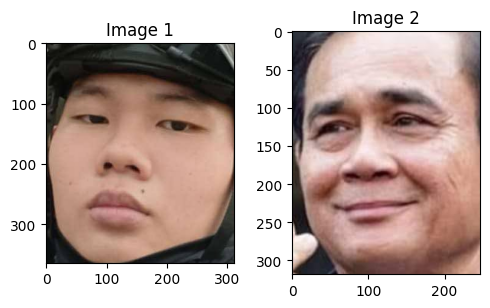

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))  # ขนาดหน้าต่างรวม

# แสดงภาพแรก
plt.subplot(1, 2, 1)  # 1 แถว 2 คอลัมน์, ภาพที่ 1
plt.imshow(Image1c)
plt.title("Image 1")
#plt.axis('off')

# แสดงภาพที่สอง
plt.subplot(1, 2, 2)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(Image2c)
plt.title("Image 2")

plt.tight_layout()
plt.show()


#image_np1 = Image1.numpy()[0]
#image_np2 = Image2.numpy()[0]


In [43]:
import numpy as np

# สมมติ embedding 2 vectors ขนาด 128 มิติ
embedding_a = em1[0]  # แปลงเป็นเวกเตอร์ 1 มิติ
embedding_b = em2[0]  # แปลงเป็นเวกเตอร์ 1 มิติ

# 1. Euclidean Distance เวคเตอร์เอามาลบกัน - 
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# 2. Cosine Similarity  # คำนวณ dot product แล้วหารด้วย norm ของแต่ละเวคเตอร์
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)



eu_dist = euclidean_distance(embedding_a, embedding_b)
cos_sim = cosine_similarity(embedding_a, embedding_b)

print("Euclidean Distance:", eu_dist)
print("Cosine Similarity:", cos_sim)
 
# เพิ่มเงื่อนไขตรวจสอบความเหมือนของใบหน้า
if eu_dist < 0.6:
    print("eu_เหมือน")
else:
    print("eu_ไม่เหมือน")

if cos_sim > 0.8:
    print("cosin_เหมือน")
else:
    print("cosin_ไม่เหมือน")

Euclidean Distance: 0.8389776
Cosine Similarity: 0.64805824
eu_ไม่เหมือน
cosin_ไม่เหมือน
